# Preparing data

Web Scraping for historical scores

In [84]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import pandas as pd
from datetime import datetime

def get_scores_from_season(url, season_start_year):
    column_names = ['date', 'season', 'team', 'opponent', 'venue', 'goals_for', 'goals_against']
    scores_df = pd.DataFrame(columns = column_names)
    driver = webdriver.Chrome()
    driver.get(url)

    cookies_accept = driver.find_element(by=By.XPATH, value = '//*[@id="onetrust-accept-btn-handler"]')
    cookies_accept.click()
    time.sleep(1)

    driver.execute_script(f'window.scrollBy(0,10000)')
    more_results = driver.find_element(by=By.CLASS_NAME, value = 'event__more--static')
    more_results.click()
    time.sleep(1)
    driver.execute_script(f'window.scrollBy(0,100000)')
    more_results.click()
    time.sleep(1)
    driver.execute_script(f'window.scrollBy(0,100000)')
    more_results.click()
    time.sleep(1)

    matches = driver.find_elements(by=By.CLASS_NAME, value ='event__match--twoLine')
    for match in matches:
        team1 = match.find_element(by=By.CLASS_NAME, value = 'event__participant--home').text
        team2 = match.find_element(by=By.CLASS_NAME, value = 'event__participant--away').text
        score1 = match.find_element(by=By.CLASS_NAME, value = 'event__score--home').text
        score2 = match.find_element(by=By.CLASS_NAME, value = 'event__score--away').text
        dateStr = match.find_element(by=By.CLASS_NAME, value = 'event__time').text


        date = datetime.strptime(dateStr, '%d.%m. %H:%M')
        if date.month > 6:
            date = date.replace(year = season_start_year)
        else:
            date = date.replace(year = season_start_year + 1)
        
        season = str(season_start_year) + '/' + str(season_start_year + 1)

        row = pd.DataFrame({'date': [date], 'season':[season], 'team': [team1], 'opponent': [team2], 'venue':['Home'], 'goals_for': [score1], 'goals_against': [score2]})
        scores_df = pd.concat([scores_df,row])
        row = pd.DataFrame({'date': [date], 'season':[season], 'team': [team2], 'opponent': [team1], 'venue':['Away'], 'goals_for': [score2], 'goals_against': [score1]})
        scores_df = pd.concat([scores_df,row])
    return scores_df

season1_df = get_scores_from_season('https://www.flashscore.pl/pilka-nozna/anglia/premier-league-2020-2021/wyniki/', 2020)
season2_df = get_scores_from_season('https://www.flashscore.pl/pilka-nozna/anglia/premier-league-2021-2022/wyniki/', 2021)

scores_df = pd.concat([season1_df, season2_df])


In [88]:
scores_df

,date,season,team,opponent,venue,goals_for,goals_against,venue_code,opponent_code,dayofweek_code,result
0,2021-05-23 17:00:00,2020/2021,Arsenal,Brighton,Home,2,0,1,3,6,W
0,2021-05-23 17:00:00,2020/2021,Brighton,Arsenal,Away,0,2,0,0,6,L
0,2021-05-23 17:00:00,2020/2021,Aston Villa,Chelsea,Home,2,1,1,5,6,W
0,2021-05-23 17:00:00,2020/2021,Chelsea,Aston Villa,Away,1,2,0,1,6,L
0,2021-05-23 17:00:00,2020/2021,Fulham,Newcastle,Home,0,2,1,14,6,L
...,...,...,...,...,...,...,...,...,...,...,...
0,2021-08-14 16:00:00,2021/2022,Aston Villa,Watford,Away,2,3,0,19,5,L
0,2021-08-14 13:30:00,2021/2022,Manchester Utd,Leeds,Home,5,1,1,9,5,W
0,2021-08-14 13:30:00,2021/2022,Leeds,Manchester Utd,Away,1,5,0,13,5,L
0,2021-08-13 21:00:00,2021/2022,Brentford,Arsenal,Home,2,0,1,0,4,W


Preparing and cleaning data

In [123]:
scores_df['date'] = pd.to_datetime(scores_df['date'])
scores_df['goals_for'] = pd.to_numeric(scores_df['goals_for'])
scores_df['goals_against'] = pd.to_numeric(scores_df['goals_against'])
scores_df['venue_code'] = scores_df['venue'].astype('category').cat.codes
scores_df['opponent_code'] = scores_df['opponent'].astype('category').cat.codes
scores_df['dayofweek'] = scores_df['date'].dt.day_name()
scores_df['dayofweek_code'] = scores_df['date'].dt.dayofweek
scores_df['month'] = scores_df['date'].dt.month_name()
scores_df['month_code'] = scores_df['date'].dt.month

scores_df['result'] = scores_df.apply(lambda row: 'W' if row.goals_for > row.goals_against else 'L' if row.goals_for < row.goals_against else 'D', axis=1)
scores_df['score'] = scores_df.apply(lambda row: 1 if row.result == 'W' else 0 if row.result == 'L' else 0.5 , axis=1)

scores_df

,date,season,team,opponent,venue,goals_for,goals_against,venue_code,opponent_code,dayofweek_code,result,dayofweek,month,month_code
0,2021-05-23 17:00:00,2020/2021,Arsenal,Brighton,Home,2,0,1,3,6,W,Sunday,May,5
0,2021-05-23 17:00:00,2020/2021,Brighton,Arsenal,Away,0,2,0,0,6,L,Sunday,May,5
0,2021-05-23 17:00:00,2020/2021,Aston Villa,Chelsea,Home,2,1,1,5,6,W,Sunday,May,5
0,2021-05-23 17:00:00,2020/2021,Chelsea,Aston Villa,Away,1,2,0,1,6,L,Sunday,May,5
0,2021-05-23 17:00:00,2020/2021,Fulham,Newcastle,Home,0,2,1,14,6,L,Sunday,May,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2021-08-14 16:00:00,2021/2022,Aston Villa,Watford,Away,2,3,0,19,5,L,Saturday,August,8
0,2021-08-14 13:30:00,2021/2022,Manchester Utd,Leeds,Home,5,1,1,9,5,W,Saturday,August,8
0,2021-08-14 13:30:00,2021/2022,Leeds,Manchester Utd,Away,1,5,0,13,5,L,Saturday,August,8
0,2021-08-13 21:00:00,2021/2022,Brentford,Arsenal,Home,2,0,1,0,4,W,Friday,August,8


# Data visualization and analysis

### Overall analysis

The dependence of the result and venue

In [111]:
import plotly.express as px

fig = px.histogram(scores_df, "result", facet_col="venue",
             color="result",
             title="Counts of results per venue",
             labels={"venue": "Venue", "result": "Result"},
             height=500, 
             facet_col_wrap=2, 
             facet_col_spacing=0.1)

fig.update_layout(showlegend=False)
fig.update_yaxes(matches=None, showticklabels=True)

Conclusion: Teams win more often at their own stadium

The dependence of the result and day of week

In [118]:
fig = px.histogram(scores_df, "result", facet_col="dayofweek",
             color="result",
             title="Counts of results per day of the week",
             labels={"dayofweek": "Day of the week", "result": "Result"},
             height=1000, 
             facet_col_wrap=4, 
             facet_col_spacing=0.1)

fig.update_layout(showlegend=False)
fig.update_yaxes(matches=None, showticklabels=True)

Conclusion: Day of the week has impact on result of match

In [124]:
fig = px.histogram(scores_df, "result", facet_col="month",
             color="result",
             title="Counts of results per day of the week",
             labels={"month": "Month", "result": "Result"},
             height=1000, 
             facet_col_wrap=4, 
             facet_col_spacing=0.1)

fig.update_layout(showlegend=False)
fig.update_yaxes(matches=None, showticklabels=True)

Conclusion: Month has impact on result of match

### Analysis for teams

The dependence of the result and opponent for given team

In [147]:
direct_confrontations_df = scores_df.pivot_table('score', 'team', 'opponent')

px.imshow(direct_confrontations_df, title="Direct confronations of teams", width=700, height=700)


Conclusion: Opponent have impact on result of given team

The dependence of the result and day of the week for given teams

In [151]:
dayofweek_df = scores_df.pivot_table('score', 'team', 'dayofweek')

px.imshow(dayofweek_df, title="Results of teams per day of week", width=700, height=700)

Conclusion: Some teams perform better in specific days of week

The dependence of the result and month for given teams

In [152]:
month_df = scores_df.pivot_table('score', 'team', 'month')

px.imshow(month_df, title="Results of teams per day of month", width=700, height=700)

Conclusion: Some teams perform better in specific months

# Machine learning

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

model = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)
train, test = train_test_split(scores_df, test_size=0.2)
predictors = ['venue_code', 'opponent_code', 'dayofweek_code', 'month_code']
model.fit(train[predictors], train['result'])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

Testing trained model

In [126]:
from sklearn.metrics import accuracy_score

preds = model.predict(test[predictors])
accuracy = accuracy_score(test['result'], preds)

print('accuracy: ' + str(accuracy))


accuracy: 0.4342105263157895


Visualization

Predicted Scores   D   L   W
Actual Scores               
D                 13  32  34
L                 13  53  42
W                  6  45  66


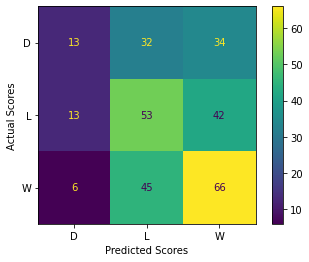

In [127]:
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(pd.crosstab(test['result'], preds, rownames=['Actual Scores'], colnames=['Predicted Scores']))

ConfusionMatrixDisplay.from_predictions(test['result'], preds)

plt.xlabel("Predicted Scores")
plt.ylabel("Actual Scores")
plt.show()


# Predict upcoming matches

Web Scraping upcoming matches

In [81]:
column_names = ['date', 'season', 'team', 'opponent', 'venue']
matches_df = pd.DataFrame(columns = column_names)
driver = webdriver.Chrome()
driver.get('https://www.flashscore.pl/pilka-nozna/anglia/premier-league/mecze/')

cookies_accept = driver.find_element(by=By.XPATH, value = '//*[@id="onetrust-accept-btn-handler"]')
cookies_accept.click()
time.sleep(1)

driver.execute_script(f'window.scrollBy(0,10000)')
more_results = driver.find_element(by=By.CLASS_NAME, value = 'event__more--static')
more_results.click()
time.sleep(1)
driver.execute_script(f'window.scrollBy(0,100000)')
more_results.click()
time.sleep(1)
driver.execute_script(f'window.scrollBy(0,100000)')
more_results.click()
time.sleep(1)

matches = driver.find_elements(by=By.CLASS_NAME, value ='event__match--twoLine')
for match in matches:
    team1 = match.find_element(by=By.CLASS_NAME, value = 'event__participant--home').text
    team2 = match.find_element(by=By.CLASS_NAME, value = 'event__participant--away').text
    dateStr = match.find_element(by=By.CLASS_NAME, value = 'event__time').text


    date = datetime.strptime(dateStr, '%d.%m. %H:%M')
    if date.month > 6:
        date = date.replace(year = 2022)
    else:
        date = date.replace(year = 2023)
        
    season = str(2022) + '/' + str(2023)

    row = pd.DataFrame({'date': [date], 'season':[season], 'team': [team1], 'opponent': [team2], 'venue':['Home']})
    matches_df = pd.concat([matches_df,row])

Preparing upcoming matches 

In [82]:
matches_df['date'] = pd.to_datetime(matches_df['date'])
matches_df['venue_code'] = matches_df['venue'].astype('category').cat.codes
matches_df['opponent_code'] = matches_df['opponent'].astype('category').cat.codes
matches_df['dayofweek_code'] = matches_df['date'].dt.dayofweek

Predict scores

In [83]:
pred = model.predict(matches_df[predictors])
matches_df['prediction'] = pred

matches_df

,date,season,team,opponent,venue,venue_code,opponent_code,dayofweek_code,prediction
0,2022-08-05 21:00:00,2022/2023,Crystal Palace,Arsenal,Home,0,0,4,W
0,2022-08-06 13:30:00,2022/2023,Fulham,Liverpool,Home,0,11,5,L
0,2022-08-06 16:00:00,2022/2023,Bournemouth,Aston Villa,Home,0,1,5,L
0,2022-08-06 16:00:00,2022/2023,Leeds,Wolves,Home,0,19,5,W
0,2022-08-06 16:00:00,2022/2023,Leicester,Brentford,Home,0,3,5,D
...,...,...,...,...,...,...,...,...,...
0,2023-05-28 17:00:00,2022/2023,Everton,Bournemouth,Home,0,2,6,L
0,2023-05-28 17:00:00,2022/2023,Leeds,Tottenham,Home,0,17,6,W
0,2023-05-28 17:00:00,2022/2023,Leicester,West Ham,Home,0,18,6,L
0,2023-05-28 17:00:00,2022/2023,Manchester Utd,Fulham,Home,0,8,6,W
